In [76]:
%pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [77]:
# python imports
import os
from tqdm import tqdm

# torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# helper functions for computer vision
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets

import argparse

import scipy.io

import matplotlib.pyplot as plt
import numpy as np

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [93]:
# Import MNIST

from torchvision.datasets import EMNIST
#torchvision.datasets.EMNIST()
# Download and Save MNIST 
digits_train = EMNIST( './emnist_data', train=True, split="mnist", download=True, transform = transforms.Compose([transforms.ToTensor(),
                                                                                                                  #transforms.RandomCrop(size = 32, padding = 2, fill=0), 
                                                                                                                  lambda img: torchvision.transforms.functional.rotate(img, -90),
                                                                                                                  lambda img: torchvision.transforms.functional.hflip(img)]))
digits_train_large = EMNIST( './emnist_data', train=True, split="digits", download=True, transform = transforms.Compose([transforms.ToTensor(),
                                                                                                                         #transforms.RandomCrop(size = 32, padding = 2, fill=0),
                                                                                                                         lambda img: torchvision.transforms.functional.rotate(img, -90),
                                                                                                                         lambda img: torchvision.transforms.functional.hflip(img)]))
letters_train = EMNIST( './emnist_data', train=True, split="letters", download=True, transform = transforms.Compose([transforms.ToTensor(),
                                                                                                                     #transforms.RandomCrop(size = 32, padding = 2, fill=0),
                                                                                                                     lambda img: torchvision.transforms.functional.rotate(img, -90),
                                                                                                                     lambda img: torchvision.transforms.functional.hflip(img)]))
letters_train.targets += 9

digits_test = EMNIST( './emnist_data', train=False, split="mnist", download=True, transform = transforms.Compose([transforms.ToTensor(),
                                                                                                                  #transforms.RandomCrop(size = 32, padding = 2, fill=0), 
                                                                                                                  lambda img: torchvision.transforms.functional.rotate(img, -90),
                                                                                                                  lambda img: torchvision.transforms.functional.hflip(img)]))
digits_test_large = EMNIST( './emnist_data', train=False, split="digits", download=True, transform = transforms.Compose([transforms.ToTensor(),
                                                                                                                         #transforms.RandomCrop(size = 32, padding = 2, fill=0),
                                                                                                                         lambda img: torchvision.transforms.functional.rotate(img, -90),
                                                                                                                         lambda img: torchvision.transforms.functional.hflip(img)]))
letters_test = EMNIST( './emnist_data', train=False, split="letters", download=True, transform = transforms.Compose([transforms.ToTensor(),
                                                                                                                     #transforms.RandomCrop(size = 32, padding = 2, fill=0),
                                                                                                                     lambda img: torchvision.transforms.functional.rotate(img, -90),
                                                                                                                     lambda img: torchvision.transforms.functional.hflip(img)]))
letters_test.targets += 9

#comb_train = torch.utils.data.ConcatDataset([digits_train,letters_train])
comb_train = digits_train_large
#comb_test = torch.utils.data.ConcatDataset([digits_test,letters_test])
comb_test = digits_test_large
#data_train = torch.utils.data.DataLoader(comb_train , batch_size=128,shuffle=True )

#data_test = torch.utils.data.DataLoader( comb_test , batch_size=128,shuffle=True )
#for batch_idx, samples in enumerate(data_train):
    #print(batch_idx, samples)

In [94]:
comb_train[5][0][0].shape

torch.Size([28, 28])

In [80]:
# for i in range(len(comb_train)):
#     temp = list(comb_train[i])
#     temp_matrix = temp[0][0].clone().T
#     temp[0][0] = temp_matrix
#     comb_train[i] = tuple(temp)

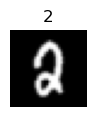

In [81]:
figure = plt.figure(figsize=(1, 1))
cols, rows = 1, 1
sample_idx = 5
img, label = comb_test[sample_idx]
figure.add_subplot(rows, cols, 1)
plt.title(label) 
plt.axis("off")
plt.imshow(img.view(32,32), cmap="gray")
#plt.show()

RuntimeError: shape '[32, 32]' is invalid for input of size 784

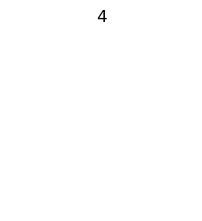

In [96]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(comb_test), size=(1,)).item()
    img, label = comb_test[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label) 
    plt.axis("off")
    plt.imshow(img.view(32,32), cmap="gray")
#plt.show()

In [110]:
class LeNet(nn.Module):
    def __init__(self, input_shape=(28, 28), num_classes=10):
        super(LeNet, self).__init__()
        # certain definitions
        self.num_classes = num_classes
        self.input_shape = input_shape
        self.conv1 = nn.Conv2d(1,6,5)
        self.conv2 = nn.Conv2d(6,16,5)
        #self.lin1 = nn.Linear(400,120)
        self.lin1 = nn.Linear(784,64)
        #self.lin2 = nn.Linear(120,84)
        self.lin2 = nn.Linear(64,num_classes)
        
    def forward(self, x):
        shape_dict = {}
        
        # neuron network
        #Layer3
        x = torch.flatten(x,1)
        shape_dict[1] = list(x.size())
        #Layer4
        x = F.relu(self.lin1(x))
        shape_dict[2] = list(x.size())
        #Layer5
        # x = F.relu(self.lin2(x))
        # shape_dict[3] = list(x.size())
        #Layer6
        out = self.lin2(x)
        shape_dict[3] = list(out.size())
        # out = self.lin3(x)
        # shape_dict[4] = list(out.size())
        '''
        # CNN
        #Layer1
        x = F.max_pool2d(F.relu(self.conv1(x)),kernel_size=2,stride=2)
        shape_dict[1] = list(x.size())
        #Layer2
        x = F.max_pool2d(F.relu(self.conv2(x)),kernel_size=2,stride=2)
        shape_dict[2] = list(x.size())
        #Layer3
        x = torch.flatten(x,1)
        shape_dict[3] = list(x.size())
        #Layer4
        x = F.relu(self.lin1(x))
        shape_dict[4] = list(x.size())
        #Layer5
        x = F.relu(self.lin2(x))
        shape_dict[5] = list(x.size())
        #Layer6
        out = self.lin3(x)
        shape_dict[6] = list(out.size())
        '''

        return out, shape_dict


def count_model_params():
    '''
    return the number of trainable parameters of LeNet.
    '''
    model = LeNet()
    model_params = 0.0
    for name, param in model.named_parameters():
        temp_result = 1
        for each in param.size():
            temp_result = temp_result*each
        model_params += temp_result
    return model_params/1000000


def train_model(model, train_loader, optimizer, criterion, epoch):
    """
    model (torch.nn.module): The model created to train
    train_loader (pytorch data loader): Training data loader
    optimizer (optimizer.*): A instance of some sort of optimizer, usually SGD
    criterion (nn.CrossEntropyLoss) : Loss function used to train the network
    epoch (int): Current epoch number
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.train()
    train_loss = 0.0
    
    for input, target in tqdm(train_loader, total=len(train_loader)):
        ###################################
        # fill in the standard training loop of forward pass,
        # backward pass, loss computation and optimizer step
        ###################################
        #might want to fix later TODO
        input = input.to(device)
        target = target.to(device)
        
        # 1) zero the parameter gradients
        optimizer.zero_grad()
        # 2) forward + backward + optimize
        output, _ = model(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Update the train_loss variable
        # .item() detaches the node from the computational graph
        # Uncomment the below line after you fill block 1 and 2
        train_loss += loss.item()

    train_loss /= len(train_loader)
    print('[Training set] Epoch: {:d}, Average loss: {:.4f}'.format(epoch+1, train_loss))

    return train_loss


def test_model(model, test_loader, epoch):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    correct = 0
    with torch.no_grad():
        for input, target in test_loader:
            input = input.to(device)
            target = target.to(device)
            output, _ = model(input)
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_acc = correct / len(test_loader.dataset)
    print('[Test set] Epoch: {:d}, Accuracy: {:.2f}%\n'.format(
        epoch+1, 100. * test_acc))

    return test_acc


In [111]:
def save_checkpoint(state, is_best,
                    file_folder="./outputs/",
                    filename='checkpoint.pth.tar'):
    """save checkpoint"""
    if not os.path.exists(file_folder):
        os.makedirs(os.path.expanduser(file_folder), exist_ok=True)
    torch.save(state, os.path.join(file_folder, filename))
    if is_best:
        # skip the optimization state
        state.pop('optimizer', None)
        torch.save(state, os.path.join(file_folder, 'model_best.pth.tar'))







In [112]:
class MyArgs:
    resume = False #"./outputs/checkpoint.pth.tar"
    epochs = 20
    lr = 0.002
    batch_size = 128
args = MyArgs()

# main function for training and testing

# set up random seed
#torch.manual_seed(0)

###################################
# setup model, loss and optimizer #
###################################

model = LeNet()

training_criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)
# optim.Adam(model.parameters(), lr=args.lr)

# set up transforms to transform the PIL Image to tensors
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

################################
# setup dataset and dataloader #
################################

train_loader = torch.utils.data.DataLoader(comb_train , batch_size=args.batch_size,shuffle=True )
test_loader = torch.utils.data.DataLoader( comb_test , batch_size=args.batch_size,shuffle=True )

################################
# start the training           #
################################
# resume from a previous checkpoint
best_acc = 0.0
start_epoch = 0
if args.resume:
    if os.path.isfile(args.resume):
        print("=> loading checkpoint '{:s}'".format(args.resume))
        checkpoint = torch.load(args.resume)
        start_epoch = checkpoint['epoch']
        best_acc = checkpoint['best_acc']
        # load model weight
        model.load_state_dict(checkpoint['state_dict'])
        # load optimizer states
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{:s}' (epoch {:d}, acc {:0.2f})".format(
            args.resume, checkpoint['epoch'], 100*best_acc))
    else:
        print("=> no checkpoint found at '{}'".format(args.resume))

# training of the model
print("Training the model ...\n")
for epoch in range(start_epoch, args.epochs):
    # train model for 1 epoch
    train_model(model, train_loader, optimizer, training_criterion, epoch)
    # evaluate the model on test_set after this epoch
    acc = test_model(model, test_loader, epoch)
    # save the current checkpoint
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_acc' : max(best_acc, acc),
        'optimizer' : optimizer.state_dict(),
        }, (acc > best_acc))
    best_acc = max(best_acc, acc)
print("Finished Training")

Training the model ...



100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:22<00:00, 22.74it/s]


[Training set] Epoch: 1, Average loss: 0.5548
[Test set] Epoch: 1, Accuracy: 91.97%



100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:22<00:00, 22.84it/s]


[Training set] Epoch: 2, Average loss: 0.2562
[Test set] Epoch: 2, Accuracy: 93.44%



100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:23<00:00, 22.47it/s]


[Training set] Epoch: 3, Average loss: 0.2179
[Test set] Epoch: 3, Accuracy: 94.25%



100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:21<00:00, 22.96it/s]


[Training set] Epoch: 4, Average loss: 0.1926
[Test set] Epoch: 4, Accuracy: 94.92%



100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:22<00:00, 22.74it/s]


[Training set] Epoch: 5, Average loss: 0.1731
[Test set] Epoch: 5, Accuracy: 95.42%



100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:21<00:00, 22.94it/s]


[Training set] Epoch: 6, Average loss: 0.1574
[Test set] Epoch: 6, Accuracy: 95.88%



100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:21<00:00, 22.96it/s]


[Training set] Epoch: 7, Average loss: 0.1447
[Test set] Epoch: 7, Accuracy: 96.09%



100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:23<00:00, 22.46it/s]


[Training set] Epoch: 8, Average loss: 0.1342
[Test set] Epoch: 8, Accuracy: 96.40%



100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:21<00:00, 22.89it/s]


[Training set] Epoch: 9, Average loss: 0.1253
[Test set] Epoch: 9, Accuracy: 96.62%



100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:21<00:00, 23.05it/s]


[Training set] Epoch: 10, Average loss: 0.1178
[Test set] Epoch: 10, Accuracy: 96.78%



100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:22<00:00, 22.73it/s]


[Training set] Epoch: 11, Average loss: 0.1113
[Test set] Epoch: 11, Accuracy: 96.95%



100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:26<00:00, 21.70it/s]


[Training set] Epoch: 12, Average loss: 0.1057
[Test set] Epoch: 12, Accuracy: 97.17%



100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:22<00:00, 22.67it/s]


[Training set] Epoch: 13, Average loss: 0.1005
[Test set] Epoch: 13, Accuracy: 97.28%



100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:21<00:00, 22.89it/s]


[Training set] Epoch: 14, Average loss: 0.0960
[Test set] Epoch: 14, Accuracy: 97.40%



100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:23<00:00, 22.54it/s]


[Training set] Epoch: 15, Average loss: 0.0919
[Test set] Epoch: 15, Accuracy: 97.42%



100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:22<00:00, 22.73it/s]


[Training set] Epoch: 16, Average loss: 0.0882
[Test set] Epoch: 16, Accuracy: 97.49%



100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:21<00:00, 22.88it/s]


[Training set] Epoch: 17, Average loss: 0.0849
[Test set] Epoch: 17, Accuracy: 97.56%



100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:25<00:00, 21.83it/s]


[Training set] Epoch: 18, Average loss: 0.0819
[Test set] Epoch: 18, Accuracy: 97.69%



100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:23<00:00, 22.35it/s]


[Training set] Epoch: 19, Average loss: 0.0792
[Test set] Epoch: 19, Accuracy: 97.73%



100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:21<00:00, 23.05it/s]


[Training set] Epoch: 20, Average loss: 0.0767
[Test set] Epoch: 20, Accuracy: 97.79%

Finished Training


In [113]:
model

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (lin1): Linear(in_features=784, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=10, bias=True)
)

In [114]:
count_model_params() *1000000

53462.0

In [115]:
model.lin1.weight

Parameter containing:
tensor([[-0.0294, -0.0313,  0.0296,  ..., -0.0333, -0.0245,  0.0176],
        [-0.0140, -0.0297, -0.0270,  ...,  0.0052,  0.0139,  0.0282],
        [-0.0006,  0.0062,  0.0300,  ...,  0.0247, -0.0096, -0.0140],
        ...,
        [-0.0038,  0.0235, -0.0321,  ..., -0.0243, -0.0104, -0.0084],
        [ 0.0305, -0.0273,  0.0197,  ..., -0.0220, -0.0327,  0.0072],
        [-0.0155, -0.0089,  0.0120,  ...,  0.0140, -0.0301,  0.0083]],
       requires_grad=True)

In [116]:
len(model.lin1.weight.reshape(-1))

50176

In [117]:
import struct
for i in range(len(model.lin1.weight.reshape(-1))):
  print("@"+hex(i)[2:].zfill(4)+" "+hex(struct.unpack('<I', struct.pack('<f', model.lin1.weight.reshape(-1)[i].item()))[0])[2:].zfill(8), end="|")
print()

@0000 bcf13493|@0001 bd006482|@0002 3cf284ee|@0003 3d089bbb|@0004 3c939ae0|@0005 3c8a7454|@0006 3d0c7c9d|@0007 3ce5482a|@0008 3ab1a0a0|@0009 3bf49340|@000a bc97b633|@000b 3b4f1850|@000c bc94fc6e|@000d 3a67afc0|@000e bc617a4a|@000f bcbf8ba8|@0010 bc34c28a|@0011 babbee20|@0012 3c2e9638|@0013 3be3ca40|@0014 3c649874|@0015 bd09d213|@0016 3d0357f5|@0017 3d09d6e5|@0018 bca606d8|@0019 3ce8c35e|@001a 3c59c218|@001b ba389d40|@001c bc45cf66|@001d bccbe163|@001e bcfeeb09|@001f bbe76dcc|@0020 baaeb419|@0021 3cb7cc10|@0022 3c84741e|@0023 3ce85630|@0024 3c81d6d7|@0025 3c10915a|@0026 bd041787|@0027 bc1e7e33|@0028 3c7c6191|@0029 3cd0bdd0|@002a 3c38b941|@002b bc27d9a8|@002c bc48f043|@002d bc9960c7|@002e bcefec85|@002f bcbbf0f9|@0030 3c80c018|@0031 3c09b18d|@0032 3cd10875|@0033 bc83d13d|@0034 bd089005|@0035 bb55ec4f|@0036 bcbca316|@0037 3aae3e60|@0038 3c366998|@0039 3cb98b13|@003a 3cf6842a|@003b bc19d0e5|@003c bcd16b1c|@003d bcdd1f07|@003e bb4ef826|@003f bd0090ed|@0040 bd601a39|@0041 bca22c38|@0042 bd83

@2a2e ba148375|@2a2f 3c16e6b2|@2a30 3d1561ef|@2a31 3d3f0faa|@2a32 bc4e45d2|@2a33 bb9f17bb|@2a34 3c64c8ff|@2a35 bc9fb6d9|@2a36 bb61a34b|@2a37 3ce385d2|@2a38 bc934664|@2a39 3bb63625|@2a3a 3c604d6b|@2a3b bbf49831|@2a3c 3cabf535|@2a3d 3d23c876|@2a3e 3bb88f78|@2a3f 3d2e9447|@2a40 bba0b91d|@2a41 3d739cc8|@2a42 ba61d471|@2a43 3b3cb84e|@2a44 3d657ff5|@2a45 3c0ddcfc|@2a46 3ca72a6c|@2a47 3d53fa9e|@2a48 3d534df4|@2a49 3d741387|@2a4a 3c20ce86|@2a4b 3af58da4|@2a4c 3ce938ca|@2a4d bb816546|@2a4e bce95fc9|@2a4f bcd4aba4|@2a50 3d004f1d|@2a51 3be74b1b|@2a52 3ad8f101|@2a53 bb96ab08|@2a54 bcd71f35|@2a55 3cbbfe8d|@2a56 bc846e45|@2a57 bc251d7b|@2a58 3ccb16f8|@2a59 3c8efd9b|@2a5a bbd38aa4|@2a5b 3c4d9442|@2a5c 3d6fd374|@2a5d 3d48766b|@2a5e 3d427255|@2a5f 3da60580|@2a60 3d0533e9|@2a61 3d63918b|@2a62 3d967aea|@2a63 3c85ad68|@2a64 3dab9157|@2a65 3d3f4168|@2a66 3da8946c|@2a67 3c80de5f|@2a68 3a5c8f4a|@2a69 bbe3f778|@2a6a 3c92fde6|@2a6b 3d3989af|@2a6c 3d1a34a1|@2a6d bc048c3e|@2a6e 3c4f6eaf|@2a6f 3c919dbe|@2a70 bcce

@53bb 3d4cdfbb|@53bc 3d71e11f|@53bd 3c19e8d4|@53be 3bd1e886|@53bf bd024992|@53c0 3c742b52|@53c1 bc3c5005|@53c2 3b4decc2|@53c3 ba74861c|@53c4 3d1eb425|@53c5 3cf19959|@53c6 3bd9e568|@53c7 3cf298dc|@53c8 3b5cedca|@53c9 3ba81e29|@53ca bd016cd6|@53cb 3d1c3503|@53cc 3d0ba1e2|@53cd bbee67b3|@53ce 3cac010c|@53cf 3da8f598|@53d0 3d8cdc85|@53d1 3dd141d1|@53d2 3d929276|@53d3 3bc90e59|@53d4 3cfc0b6c|@53d5 3cfe6864|@53d6 3c25a3af|@53d7 3d078ab3|@53d8 bc49a091|@53d9 bd154348|@53da bd9e7a6a|@53db bd11207d|@53dc bd8320b7|@53dd bd9fe8a3|@53de bd9ec595|@53df bd9569f2|@53e0 bbb28e24|@53e1 3cb6e0fd|@53e2 3cdd18dd|@53e3 bc92a4b0|@53e4 3ced6f15|@53e5 3c109fe1|@53e6 3d11795f|@53e7 3c14252e|@53e8 3d23062c|@53e9 3d2b494d|@53ea 3c66fae7|@53eb 3da43217|@53ec 3d6a3f1f|@53ed 3d156881|@53ee bc18e885|@53ef 3d2567f8|@53f0 bcd27399|@53f1 3d27d2d1|@53f2 3d521ea0|@53f3 3ce1b2d2|@53f4 3c5a1fda|@53f5 bd2d50a7|@53f6 bd833e83|@53f7 bd4e58b8|@53f8 be1547b7|@53f9 bde090fb|@53fa bde27e5a|@53fb bd5ff3fb|@53fc bd49a718|@53fd bd0f

@7dea bd840cff|@7deb bd95bc87|@7dec bd58cc00|@7ded bb7af2b9|@7dee bc8c62d6|@7def 3cce6967|@7df0 3cd5a3a6|@7df1 3da056d8|@7df2 3dfa6424|@7df3 3e067318|@7df4 3e02292c|@7df5 3dd3985e|@7df6 3dc82eaa|@7df7 3d81fd04|@7df8 3d84c52a|@7df9 3cfd9319|@7dfa bc13cec8|@7dfb bcba1522|@7dfc bb6e0412|@7dfd 3bdac689|@7dfe bcf50ad9|@7dff 3d0f1af3|@7e00 3d1115d6|@7e01 3cdbd686|@7e02 3ca5dc84|@7e03 bd5d3712|@7e04 bd89a85b|@7e05 bd7b2c6e|@7e06 3bd49acc|@7e07 3c3d9ad7|@7e08 bcd5dc4f|@7e09 bc16659f|@7e0a 3cfe33b6|@7e0b 3cace9e7|@7e0c 3d1b18c7|@7e0d 3d958005|@7e0e 3d01f3b6|@7e0f 3db1e0ab|@7e10 3d86f882|@7e11 3d365bd5|@7e12 bc923654|@7e13 3d801815|@7e14 3c3ca738|@7e15 3ca4135a|@7e16 bc345f01|@7e17 bca4ca09|@7e18 bcadce16|@7e19 ba022c66|@7e1a 3cbb10cc|@7e1b bcdbd51c|@7e1c 3b936af2|@7e1d bcb3bd8a|@7e1e bd3867bd|@7e1f bd8cc8f0|@7e20 bca64977|@7e21 bc347152|@7e22 3c3598fd|@7e23 bd1164f8|@7e24 bc9a2f44|@7e25 bd07bae3|@7e26 bcace0c0|@7e27 3c540577|@7e28 3d2bf4d5|@7e29 3ba4daa4|@7e2a 3c9207d4|@7e2b 3bd3b753|@7e2c 3d0c

@a869 3ca1d156|@a86a 3c584e74|@a86b bb7b3c30|@a86c 3c2cc928|@a86d 3c6120d4|@a86e 3c80f88c|@a86f bcb3e045|@a870 bcb1be28|@a871 bce3654e|@a872 3d06b45d|@a873 bbb0c138|@a874 bd09d4e2|@a875 3bb75470|@a876 bc1b3f26|@a877 3d0189d7|@a878 3bf7f280|@a879 3b296e60|@a87a bcf8f73e|@a87b 3cd6e51e|@a87c 3d0bade7|@a87d bcdfe6a0|@a87e bcfeb52e|@a87f bc500506|@a880 bcb4465c|@a881 bc65e70e|@a882 bca2865c|@a883 3d0dc16f|@a884 bc48e7ca|@a885 bc98bf77|@a886 3cb47d52|@a887 3cbb4b7c|@a888 bcb85dca|@a889 bc4cc592|@a88a bba61048|@a88b bc4c272e|@a88c 3b3ebe60|@a88d bbe37480|@a88e 3d01b42e|@a88f bcafa24b|@a890 bcca1957|@a891 3c9b0254|@a892 bbae6c2c|@a893 3be84afc|@a894 393f5a5a|@a895 bc084d51|@a896 bc7db330|@a897 bca3fce0|@a898 bc6652b4|@a899 bbdc53e2|@a89a bc7195c0|@a89b 3cbdfd02|@a89c bc5be6a4|@a89d bc806467|@a89e 3c807b87|@a89f bcaaa18f|@a8a0 bc5db2b7|@a8a1 bb2873b9|@a8a2 3b8c7870|@a8a3 3c89c246|@a8a4 ba936ffb|@a8a5 3d0ae9e7|@a8a6 bccfc8cb|@a8a7 3cb0af9e|@a8a8 bc776dd4|@a8a9 bd0d3c14|@a8aa bcad2e37|@a8ab bc64

In [118]:
for i in range(len(model.lin2.weight.reshape(-1))):
  print("@"+hex(i+len(model.lin1.weight.reshape(-1)))[2:].zfill(4)+" "+hex(struct.unpack('<I', struct.pack('<f', model.lin2.weight.reshape(-1)[i].item()))[0])[2:].zfill(8), end="|")
print()

@c400 3e4eb75b|@c401 bef55a22|@c402 bd8fc1c9|@c403 bf03af14|@c404 3d88e268|@c405 beac30da|@c406 bec6eb0b|@c407 be248a25|@c408 3ee3fb51|@c409 bcccbcde|@c40a 3d2bc023|@c40b bde30beb|@c40c be136939|@c40d bde11331|@c40e 3ef0db4d|@c40f be812884|@c410 bf2eb944|@c411 be5f4d66|@c412 3e78117e|@c413 3e549e6b|@c414 bdc0ec63|@c415 3e87263d|@c416 3d9874c5|@c417 3ea1306c|@c418 3eb7a226|@c419 3e8946c2|@c41a 3dc7ec77|@c41b bcc43eb2|@c41c bede32ff|@c41d 3da19944|@c41e bf44a988|@c41f 3eb9f8e2|@c420 be860758|@c421 3eace408|@c422 3f204b67|@c423 bbb35685|@c424 be116976|@c425 3eb1cac5|@c426 bdbef58b|@c427 3eceea30|@c428 3e8f7eef|@c429 bea273de|@c42a 3d275fa5|@c42b 3ec86f3c|@c42c bf610139|@c42d 3d9ae1e8|@c42e 3f2c4d28|@c42f beb190b1|@c430 bd598c70|@c431 be9bf3ce|@c432 bda01dfa|@c433 3ed56cfd|@c434 3f0152df|@c435 be45d499|@c436 bd45e3ed|@c437 bdfe56a3|@c438 3e5adbb6|@c439 bec0dfb1|@c43a be33c78e|@c43b bedbdecc|@c43c 3e69f9d8|@c43d bf1a834f|@c43e 3ddc857b|@c43f bd06f076|@c440 be61927b|@c441 bd41f1f8|@c442 3cc9

In [119]:
count_model_params() * 1000000

53462.0